Check if the bilinear interpolation in PyTorch protects against Moire patterns.

In [1]:
from PIL import Image 
import numpy as np

# From wikipedia
im = Image.open(r"Moire_pattern_of_bricks.jpg") 
  
im = np.array(im)[((756-512) // 2):-((756-512) // 2), ((622-512) // 2):-((622-512) // 2), :]
im.shape

(512, 512, 3)

In [14]:
im_t.shape

torch.Size([1, 3, 512, 512])

Text(0.5, 1.0, 'Downsampled with dyadic\nsmoothing and downsampling')

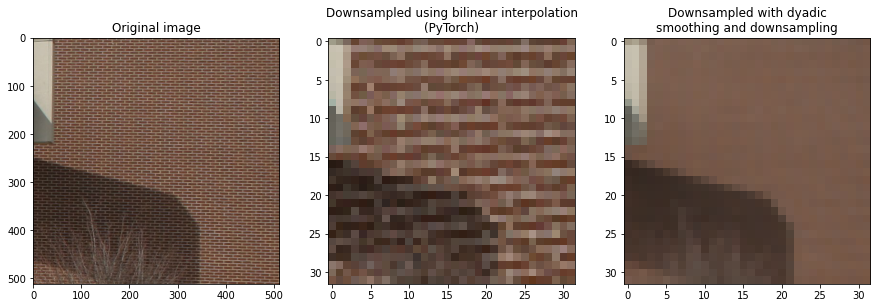

In [33]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def downsample_2d(X, sz):
    """
    Downsamples a stack of square images.
    
    Args:
        X: a stack of images (batch, channels, ny, ny).
        sz: the desired size of images.
        
    Returns:
        The downsampled images, a tensor of shape (batch, channel, sz, sz)
    """
    kernel = torch.tensor([[.25, .5, .25], 
                           [.5, 1, .5], 
                           [.25, .5, .25]], device=X.device).reshape(1, 1, 3, 3)
    kernel = kernel.repeat((X.shape[1], 1, 1, 1))
    while sz < X.shape[-1] / 2:
        # Downsample by a factor 2 with smoothing
        mask = torch.ones(1, *X.shape[1:])
        mask = F.conv2d(mask, kernel, groups=X.shape[1], stride=2, padding=1)
        X = F.conv2d(X, kernel, groups=X.shape[1], stride=2, padding=1)
        
        # Normalize the edges and corners.
        X = X = X / mask
    
    return F.interpolate(X, size=sz, mode='bilinear')

im_t = torch.tensor(im, dtype=torch.float).permute(2, 0, 1).unsqueeze(0)
downsampled = F.interpolate(im_t, scale_factor=.0625, mode='bilinear')
downsampled = downsampled.squeeze().permute(1, 2, 0).cpu().numpy().astype(np.uint8)

downsampled_good = downsample_2d(im_t, 32).squeeze().permute(1, 2, 0).cpu().numpy().astype(np.uint8)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(im)
plt.title('Original image')
plt.subplot(132)
plt.imshow(downsampled)
plt.title('Downsampled using bilinear interpolation\n(PyTorch)')
plt.subplot(133)
plt.imshow(downsampled_good)
plt.title('Downsampled with dyadic\nsmoothing and downsampling')